In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# -------------------------------
# Utility Functions
# -------------------------------

def load_and_clean_options_data(call_path, put_path):
    def clean(df):
        df.columns = [col.strip() for col in df.columns]
        df = df[['Symbol', 'Date', 'Expiry', 'Option type', 'Strike Price', 'Close']].dropna()
        df['Date'] = pd.to_datetime(df['Date'], format='%d%b%Y')
        df['Expiry'] = pd.to_datetime(df['Expiry'], format='%d%b%Y')
        return df

    call_df = clean(pd.read_csv(call_path))
    put_df = clean(pd.read_csv(put_path))

    return pd.concat([call_df, put_df], ignore_index=True).sort_values('Date').reset_index(drop=True)


def load_and_clean_historical_data(path):
    df = pd.read_csv(path)
    df.columns = [col.strip() for col in df.columns]
    df.dropna(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')
    df.set_index('Date', inplace=True)
    return df


def compute_annual_volatility(historical_df):
    log_returns = np.log(historical_df["Close"] / historical_df["Close"].shift(1))
    return log_returns.std() * np.sqrt(252)


In [ ]:
# -------------------------------
# Pricing Models
# -------------------------------

def black_scholes(S, K, T, r, sigma, option_type='CE'):
    if T == 0 or sigma == 0:
        return max(0, S - K) if option_type == 'CE' else max(0, K - S)

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'CE':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def binomial_model(S, K, T, r, sigma, steps=10, option_type='CE'):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)

    prices = np.array([S * (u ** (steps - i)) * (d ** i) for i in range(steps + 1)])

    if option_type == 'CE':
        values = np.maximum(prices - K, 0)
    else:
        values = np.maximum(K - prices, 0)

    for _ in range(steps):
        values = discount * (p * values[:-1] + (1 - p) * values[1:])

    return values[0]

In [11]:
# -------------------------------
# Evaluation & Plotting
# -------------------------------

def evaluate_models(options_df, historical_df, r, sigma, binomial_steps=10):
    results = []

    for _, row in options_df.iterrows():
        try:
            S = historical_df.loc[row['Date'], 'Close']
        except KeyError:
            continue  # Skip if no historical price available

        K = row['Strike Price']
        T = (row['Expiry'] - row['Date']).days / 365.0
        if T <= 0:
            continue

        market_price = row['Close']
        option_type = row['Option type']

        bs_price = black_scholes(S, K, T, r, sigma, option_type)
        bin_price = binomial_model(S, K, T, r, sigma, steps=binomial_steps, option_type=option_type)

        results.append({
            'Date': row['Date'],
            'Type': option_type,
            'Strike': K,
            'Expiry': row['Expiry'],
            'Market Price': market_price,
            'BS Price': bs_price,
            'Binomial Price': bin_price,
            'BS Error': abs(bs_price - market_price),
            'Binomial Error': abs(bin_price - market_price),
            '% BS Error': abs(bs_price - market_price) / market_price,
            '% Binomial Error': abs(bin_price - market_price) / market_price
        })

    return pd.DataFrame(results)


def plot_errors(results_df, title_suffix, binomial_steps):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Date', y='% BS Error', data=results_df, label='Black-Scholes', marker='o')
    sns.lineplot(x='Date', y='% Binomial Error', data=results_df, label=f'Binomial ({binomial_steps} steps)', marker='s')

    plt.xlabel('Date')
    plt.ylabel('Absolute % Error')
    plt.title(f'Relative Error of Model Prices vs Market Prices Over Time\n{title_suffix}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [12]:
# -------------------------------
# Main Execution Flow
# -------------------------------

def run_analysis(call_path, put_path, hist_path, r, binomial_steps=10, title_suffix=''):
    # Load and prepare data
    historical_df = load_and_clean_historical_data(hist_path)
    sigma = compute_annual_volatility(historical_df)
    options_df = load_and_clean_options_data(call_path, put_path)

    # Evaluate
    results_df = evaluate_models(options_df, historical_df, r, sigma, binomial_steps=binomial_steps)

    # Print summary
    print(f"\nAnalysis: {title_suffix}")
    print(f"Mean % Error (Black-Scholes): {results_df['% BS Error'].mean():.4f}")
    print(f"Mean % Error (Binomial): {results_df['% Binomial Error'].mean():.4f}")
    print(f"Std Dev of % Error (Black-Scholes): {results_df['% BS Error'].std():.4f}")
    print(f"Std Dev of % Error (Binomial): {results_df['% Binomial Error'].std():.4f}")

    # Plot
    plot_errors(results_df, title_suffix, binomial_steps)


In [13]:
# -------------------------------
# Run both 1-month and 3-month scenarios
# -------------------------------

r = 0.069  # 3-month government bond yield

# 1-month expiry: stable pre-election scenario
run_analysis(
    call_path='datasets/nifty50_options_data.csv',
    put_path='datasets/nifty50_options_data_put.csv',
    hist_path='datasets/nifty50_historical.csv',
    r=r,
    binomial_steps=2,
    title_suffix='1-Month Expiry During Low Volatility (Pre-Election)'
)

# 3-month expiry: event-driven election period
run_analysis(
    call_path='datasets/high_expiry_nifty50_options_data.csv',
    put_path='datasets/high_expiry_options_data_put.csv',
    hist_path='datasets/nifty50_historical.csv',
    r=r,
    binomial_steps=2,
    title_suffix='3-Month Expiry During Event-Driven Low Volatility (Elections)'
)

ValueError: time data "01JAN2016" doesn't match format "%d-%b-%Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

Mean % Error (Black-Scholes): -0.2435
Mean % Error (Binomial): -0.2604
Std Dev of % Error (Black-Scholes): 0.6195
Std Dev of % Error (Binomial): 0.6054


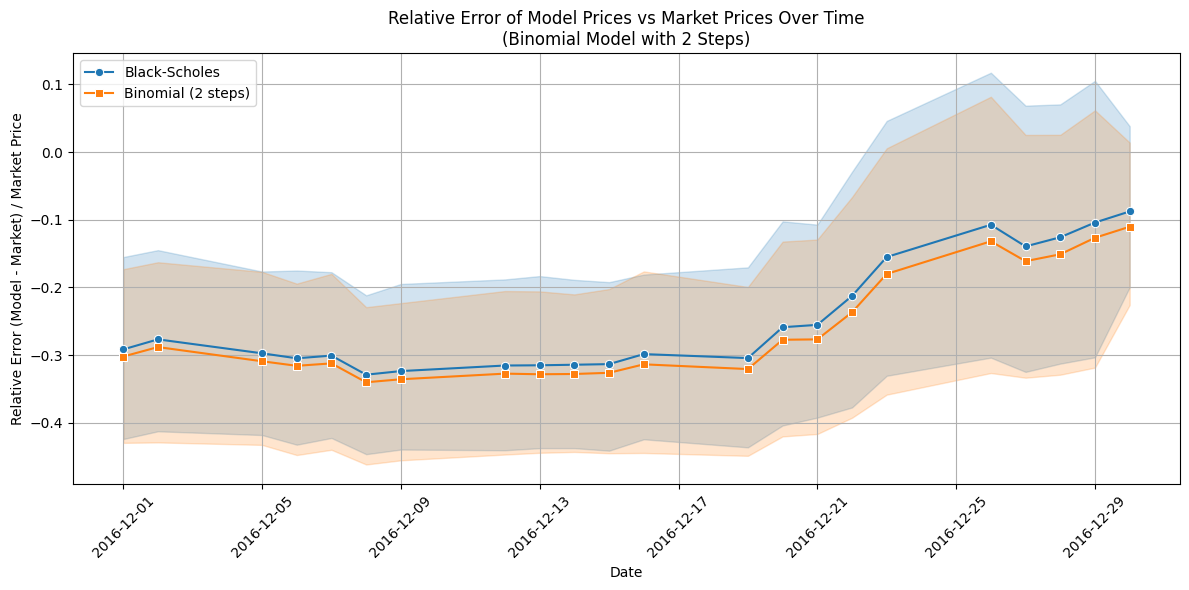

In [7]:
# Summary statistics
print(f"Mean % Error (Black-Scholes): {results_df['% BS Error'].mean():.4f}")
print(f"Mean % Error (Binomial): {results_df['% Binomial Error'].mean():.4f}")
print(f"Std Dev of % Error (Black-Scholes): {results_df['% BS Error'].std():.4f}")
print(f"Std Dev of % Error (Binomial): {results_df['% Binomial Error'].std():.4f}")

# Plot: Relative Error Comparison
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='% BS Error', data=results_df, label='Black-Scholes', marker='o')
sns.lineplot(x='Date', y='% Binomial Error', data=results_df, label='Binomial (2 steps)', marker='s')

plt.xlabel('Date')
plt.ylabel('Relative Error (Model - Market) / Market Price')
plt.title('Relative Error of Model Prices vs Market Prices Over Time\n(Binomial Model with 2 Steps)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Optional: save figure
# plt.savefig("relative_error_comparison_2steps.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()